In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Import util packages
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('..'))
from utils import construct_url, download_file, load_file, save_file

In [4]:
# Download the file
file_id = "1g7bh8mtpwa_VWKxfjMaDH8FngiV8ieXo"

download_url = construct_url(file_id)
download_file(download_url)

# Load the data
store_data, train_data, test_data, sample_submission = load_file()

Downloading...
From: https://docs.google.com/uc?export=download&id=1g7bh8mtpwa_VWKxfjMaDH8FngiV8ieXo
To: /Users/mac/10a/10-academy-week-4/data/rossmann_data.zip
100%|██████████| 7.33M/7.33M [00:02<00:00, 3.32MB/s]
/Users/mac/10a/10-academy-week-4/utils/data_utils.py:20: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(f"{csv_file_path}train.csv")


In [5]:
# Preview the store data

print(store_data.describe())

            Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1

In [6]:
# Preview the train and test data
print(train_data.describe())
print(test_data.describe())


              Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.00000

In [7]:
# Preview the sample submission

print(sample_submission.head())

   Id  Sales
0   1      0
1   2      0
2   3      0
3   4      0
4   5      0


In [8]:
# Data cleaning

# Handle missing values in store.csv
store_data["CompetitionDistance"] = store_data["CompetitionDistance"].fillna(store_data["CompetitionDistance"].max() * 10)
store_data["CompetitionOpenSinceMonth"] = store_data["CompetitionOpenSinceMonth"].fillna(0)
store_data["CompetitionOpenSinceYear"] = store_data["CompetitionOpenSinceYear"].fillna(0)
store_data["Promo2SinceWeek"] = store_data["Promo2SinceWeek"].fillna(0)
store_data["Promo2SinceYear"] = store_data["Promo2SinceYear"].fillna(0)
store_data["PromoInterval"] = store_data["PromoInterval"].fillna("None")

In [9]:
# Parse date in train and test data
train_data["Date"] = pd.to_datetime(train_data["Date"])
test_data["Date"] = pd.to_datetime(test_data["Date"])

In [10]:
# Add date features
for df in [train_data, test_data]:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["Weekday"] = df["Date"].dt.weekday
    df["IsWeekend"] = df["Weekday"] >= 5

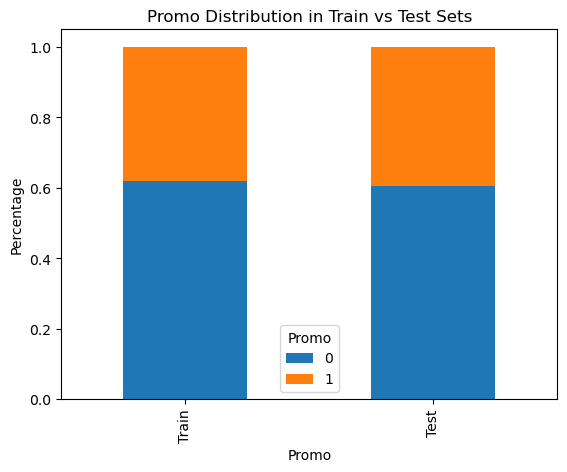

In [11]:
# EXPLORATORY ANALYSIS

# 1. Check for Promo Distribution in Training and Test Sets
def plot_promo_distribution():
    train_promo = train_data["Promo"].value_counts(normalize=True)
    test_promo = test_data["Promo"].value_counts(normalize=True)
    promo_df = pd.DataFrame({"Train": train_promo, "Test": test_promo}).T
    promo_df.plot(kind="bar", stacked=True)
    plt.title("Promo Distribution in Train vs Test Sets")
    plt.ylabel("Percentage")
    plt.xlabel("Promo")
    plt.show()

plot_promo_distribution()

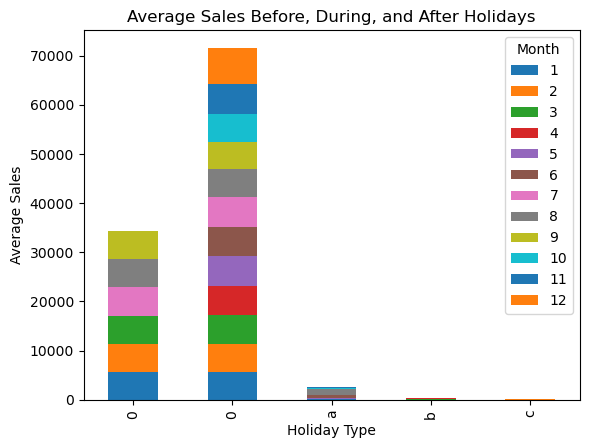

In [12]:
# 2. Sales Behavior Before, During, and After Holidays
def plot_sales_around_holidays():
    holiday_sales = train_data.groupby(["StateHoliday", "Month"])["Sales"].mean().unstack()
    holiday_sales.plot(kind="bar", stacked=True)
    plt.title("Average Sales Before, During, and After Holidays")
    plt.ylabel("Average Sales")
    plt.xlabel("Holiday Type")
    plt.show()

plot_sales_around_holidays()

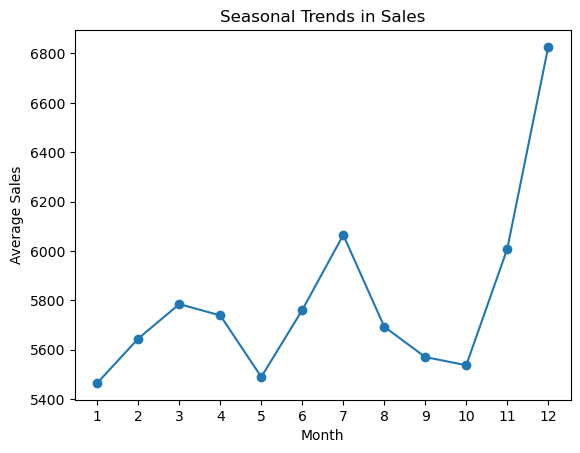

In [13]:
# 3. Seasonal Purchase Behaviors
def plot_seasonal_behavior():
    monthly_sales = train_data.groupby("Month")["Sales"].mean()
    monthly_sales.plot(kind="line", marker="o")
    plt.title("Seasonal Trends in Sales")
    plt.ylabel("Average Sales")
    plt.xlabel("Month")
    plt.xticks(range(1, 13))
    plt.show()

plot_seasonal_behavior()

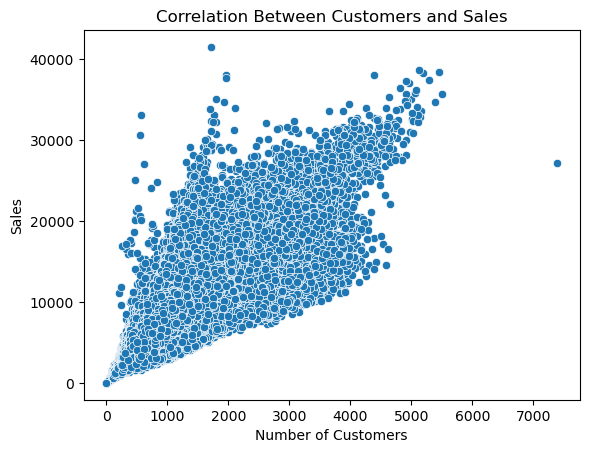

In [14]:
# 4. Correlation Between Sales and Customers
def plot_sales_customers_correlation():
    sns.scatterplot(x="Customers", y="Sales", data=train_data)
    plt.title("Correlation Between Customers and Sales")
    plt.xlabel("Number of Customers")
    plt.ylabel("Sales")
    plt.show()

plot_sales_customers_correlation()

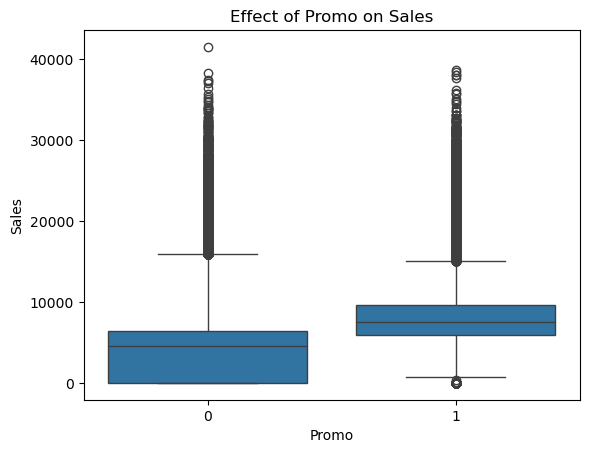

In [15]:
# 5. Promo Effect on Sales
def plot_promo_effect():
    sns.boxplot(x="Promo", y="Sales", data=train_data)
    plt.title("Effect of Promo on Sales")
    plt.xlabel("Promo")
    plt.ylabel("Sales")
    plt.show()

plot_promo_effect()

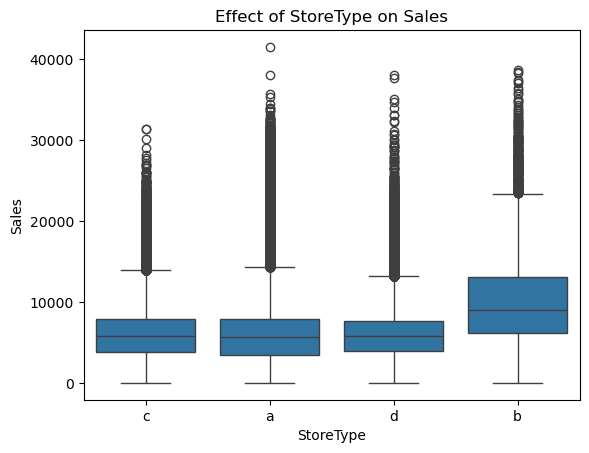

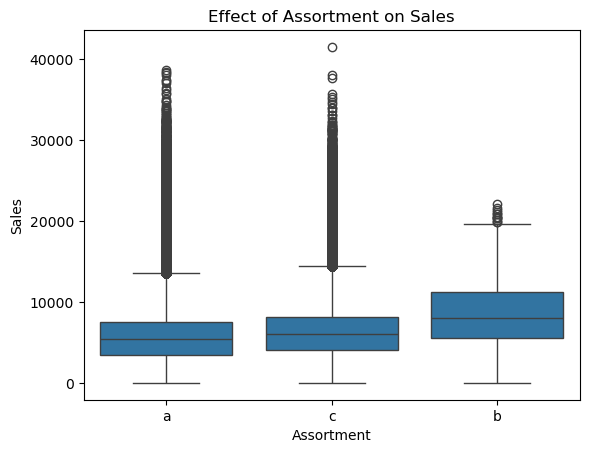

In [16]:
# 6. Effect of StoreType and Assortment
def plot_storetype_assortment_effect():
    store_sales = train_data.merge(store_data, on="Store")
    sns.boxplot(x="StoreType", y="Sales", data=store_sales)
    plt.title("Effect of StoreType on Sales")
    plt.xlabel("StoreType")
    plt.ylabel("Sales")
    plt.show()

    sns.boxplot(x="Assortment", y="Sales", data=store_sales)
    plt.title("Effect of Assortment on Sales")
    plt.xlabel("Assortment")
    plt.ylabel("Sales")
    plt.show()

plot_storetype_assortment_effect()

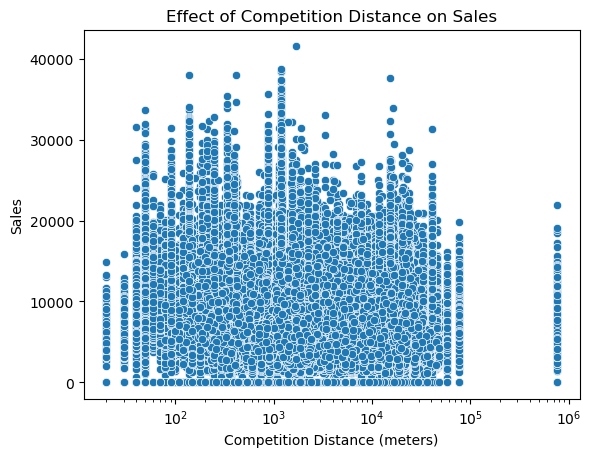

In [17]:
# 7. Effect of Competition Distance
def plot_competition_effect():
    store_sales = train_data.merge(store_data, on="Store")
    sns.scatterplot(x="CompetitionDistance", y="Sales", data=store_sales)
    plt.title("Effect of Competition Distance on Sales")
    plt.xlabel("Competition Distance (meters)")
    plt.ylabel("Sales")
    plt.xscale("log")  # Log scale for better visualization
    plt.show()

plot_competition_effect()

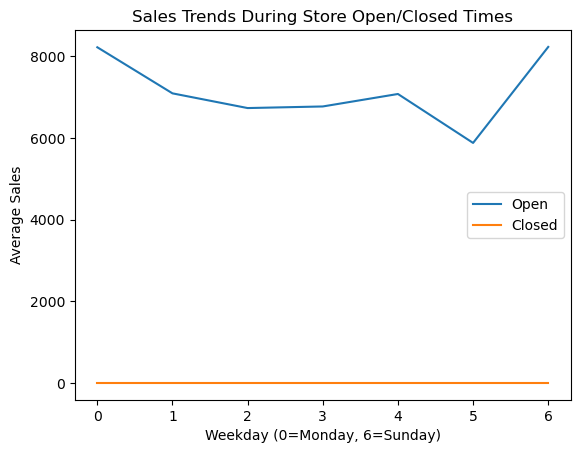

In [18]:
# 8. Sales Trends During Store Opening and Closing Times
def plot_open_close_trends():
    open_sales = train_data[train_data["Open"] == 1].groupby("Weekday")["Sales"].mean()
    closed_sales = train_data[train_data["Open"] == 0].groupby("Weekday")["Sales"].mean()

    open_sales.plot(kind="line", label="Open")
    closed_sales.plot(kind="line", label="Closed")
    plt.legend()
    plt.title("Sales Trends During Store Open/Closed Times")
    plt.xlabel("Weekday (0=Monday, 6=Sunday)")
    plt.ylabel("Average Sales")
    plt.show()

plot_open_close_trends()

In [21]:
# Save cleaned data

save_file(train_data, "cleaned_train.csv")
save_file(test_data, "cleaned_test.csv")